# Raster Calculation

$$
\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}
$$


![Alt Text](https://carpentries-incubator.github.io/geospatial-python/fig/E09/PONE-NDVI.jpg)

In [1]:
# Load the search json catalogue

import pystac
items = pystac.ItemCollection.from_file("search.json")

items

In [2]:
# List the URL of red and nir assets of item with index 2

red_uri = items[2].assets["red"].href
nir_uri = items[2].assets["nir"].href

In [3]:
red_uri

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/31/U/FU/2020/3/S2B_31UFU_20200326_0_L2A/B04.tif'

In [4]:
nir_uri

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/31/U/FU/2020/3/S2B_31UFU_20200326_0_L2A/B08.tif'

In [5]:
import rioxarray

red = rioxarray.open_rasterio(red_uri, masked=True)
nir = rioxarray.open_rasterio(nir_uri, masked=True)

In [6]:
red

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 482MB
[120560400 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 88kB 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    scale_factor:        1.0
    add_offset:          0.0

In [7]:
red_nomask = rioxarray.open_rasterio(red_uri)

In [8]:
red_nomask

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 88kB 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [9]:
red_nomask.rio.nodata

np.uint16(0)

In [10]:
# Clip the red and nir rasters
bbox = (629_000, 5_804_000, 639_000, 5_814_000)
red_clip = red.rio.clip_box(*bbox)
nir_clip = nir.rio.clip_box(*bbox)

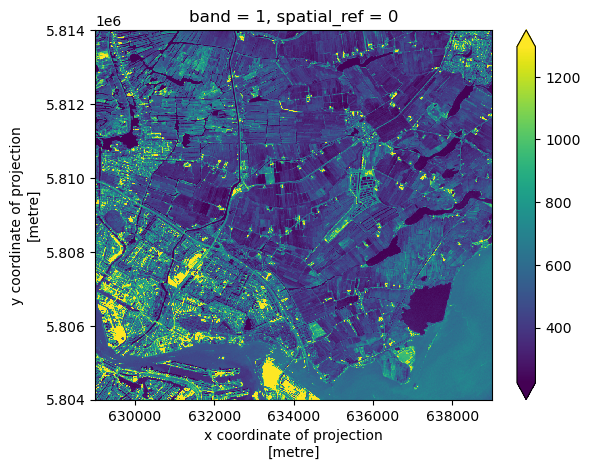

In [12]:
# Plot red clip

red_clip.plot(robust=True)

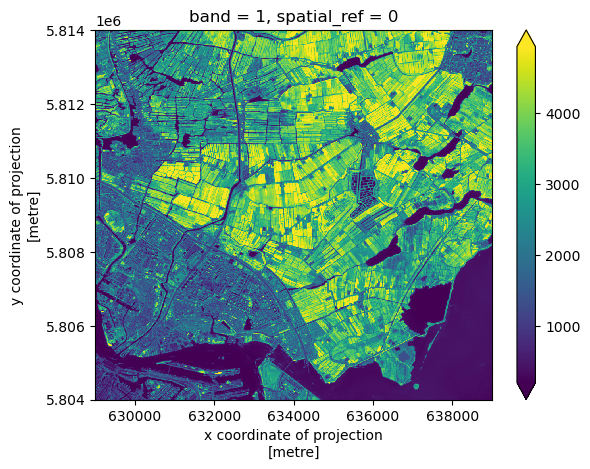

In [13]:
# Plot nir

nir_clip.plot(robust=True)

In [14]:
print(red_clip.shape, nir_clip.shape)

(1, 1000, 1000) (1, 1000, 1000)


In [15]:
# Reproject red to nir

red_clip_matched = red_clip.rio.reproject_match(nir_clip)

In [16]:
print(red_clip_matched.shape)

(1, 1000, 1000)


In [21]:
# Calculate ndvi
ndvi = (nir_clip - red_clip_matched) / (nir_clip + red_clip_matched)

In [ ]:
ndvi

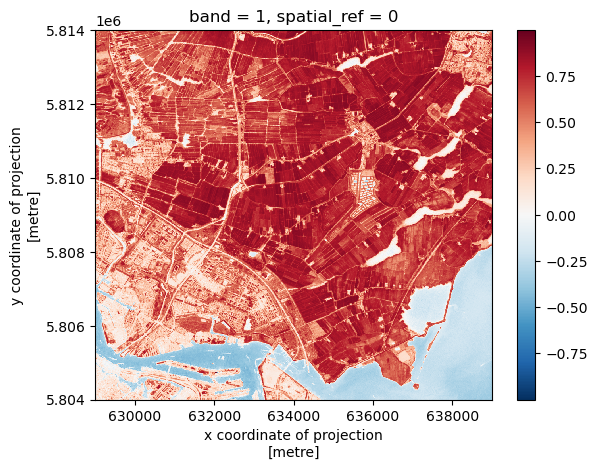

In [18]:
ndvi.plot()

(array([5.00000e+00, 2.00000e+00, 1.06730e+04, 8.93370e+04, 3.18520e+04,
        7.91100e+04, 1.11035e+05, 1.56887e+05, 3.05459e+05, 2.15636e+05]),
 array([-9.98356640e-01, -7.98577428e-01, -5.98798275e-01, -3.99019063e-01,
        -1.99239910e-01,  5.39243221e-04,  2.00318515e-01,  4.00097668e-01,
         5.99876821e-01,  7.99655974e-01,  9.99435186e-01]),
 <BarContainer object of 10 artists>)

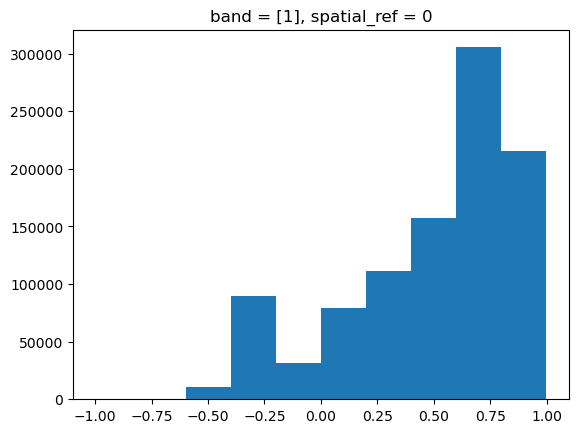

In [19]:
# Plot the histogram

ndvi.plot.hist()

In [23]:
# Interpolation to handle the nan values

ndvi_nonan = ndvi.interpolate_na(dim="x")
ndvi_nonan.rio.to_raster("NDVI.tif")

In [24]:
# Classify NDVI values into 4 categories

import numpy as np
import xarray

# Define the bins for continous pixel values
class_bins = (-1, 0.0 , 0.2, 0.7, 1)

# Use xarray and numpy function to classify the ndvi values
ndvi_classified = xarray.apply_ufunc(
    np.digitize,
    ndvi_nonan,
    class_bins
)

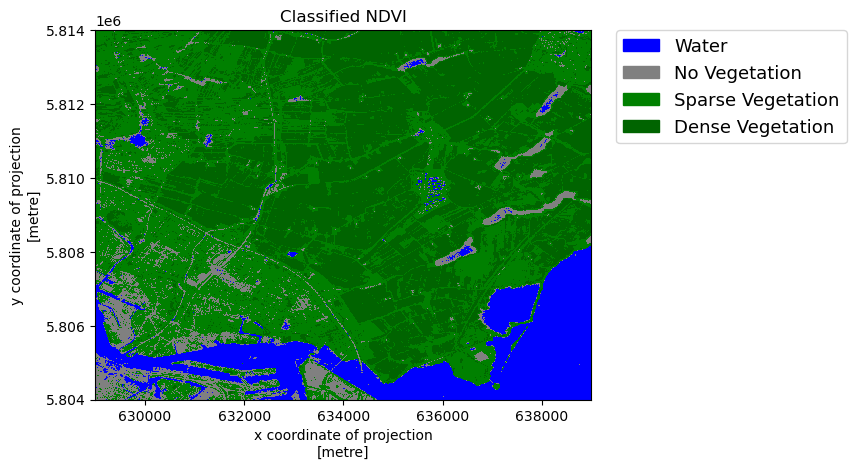

In [25]:
# Visualize
import earthpy.plot as ep
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

# Define the color map for each category
ndvi_colors = ["blue", "gray", "green", "darkgreen"]
ndvi_cmap = ListedColormap(ndvi_colors)

# Define class names for legends
category_names = [
    "Water",
    "No Vegetation",
    "Sparse Vegetation",
    "Dense Vegetation"
]

# Define index
category_indices = list(range(len(category_names)))

# Make plot
im = ndvi_classified.plot(cmap=ndvi_cmap, add_colorbar=False)
plt.title("Classified NDVI")
# Make legend
ep.draw_legend(im_ax=im, classes=category_indices, titles=category_names)

# Save figures
plt.savefig("NDVI_classified.png", bbox_inches="tight", dpi=300)

In [26]:
ndvi_classified.rio.to_raster("NDVI_classified.tif", dtype="int32")